In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Load 100 samples of data
Data loaded!
==> Adam
Optimizer: Adam, Epoch [1/10], Train Loss: 2.5274, Train Acc: 17.00%, Test Loss: 2.1121, Test Acc: 13.00%
Optimizer: Adam, Epoch [2/10], Train Loss: 2.1949, Train Acc: 24.00%, Test Loss: 2.9378, Test Acc: 16.00%
Optimizer: Adam, Epoch [3/10], Train Loss: 1.6682, Train Acc: 40.00%, Test Loss: 2.1019, Test Acc: 32.00%
Optimizer: Adam, Epoch [4/10], Train Loss: 1.6464, Train Acc: 32.00%, Test Loss: 2.1482, Test Acc: 26.00%
Optimizer: Adam, Epoch [5/10], Train Loss: 1.4884, Train Acc: 47.00%, Test Loss: 2.1171, Test Acc: 29.00%
Optimizer: Adam, Epoch [6/10], Train Loss: 1.3621, Train Acc: 52.00%, Test Loss: 2.0094, Test Acc: 30.00%
Optimizer: Adam, Epoch [7/10], Train Loss: 1.4830, Train Acc: 50.00%, Test Loss: 2.1533, Test Acc: 26.00%
Optimizer: Adam, Epoch [8/10], Train Loss: 1.1249, Train Acc: 57.00%, Test Loss: 2.0175, Test 

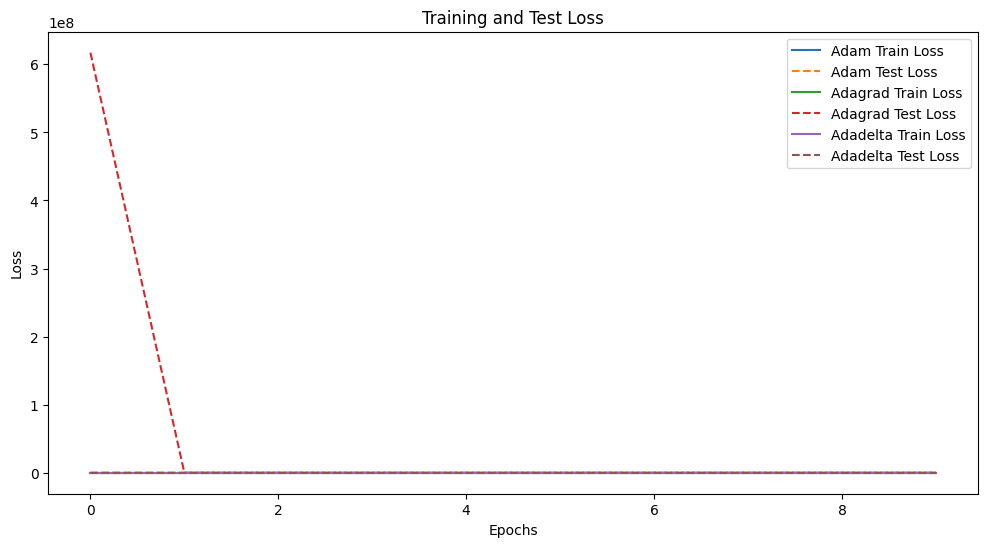

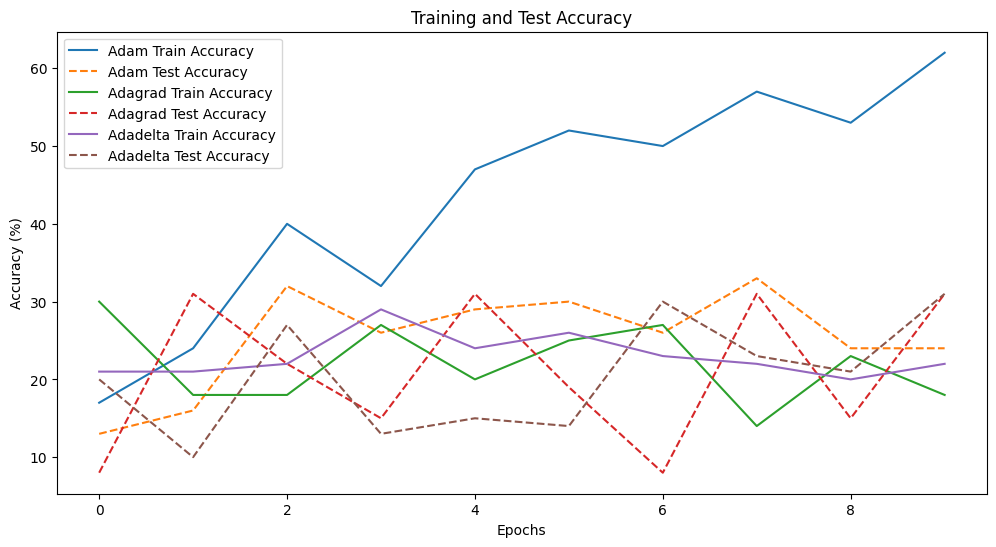

Adam Final Top-5 Test Accuracy: 33.00%
Adagrad Final Top-5 Test Accuracy: 31.00%
Adadelta Final Top-5 Test Accuracy: 31.00%


In [2]:
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Reduce image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load SVHN dataset
train_dataset = datasets.SVHN(root='./data', split='train', transform=transform, download=True)
test_dataset = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

# Filter out samples with labels greater than 5
train_dataset.data = train_dataset.data[train_dataset.labels <= 5]
train_dataset.labels = train_dataset.labels[train_dataset.labels <= 5]

test_dataset.data = test_dataset.data[test_dataset.labels <= 5]
test_dataset.labels = test_dataset.labels[test_dataset.labels <= 5]

print('Load 100 samples of data')
# Load only 100 samples of the dataset
train_dataset.data = train_dataset.data[:100]
train_dataset.labels = train_dataset.labels[:100]

test_dataset.data = test_dataset.data[:100]
test_dataset.labels = test_dataset.labels[:100]

# Define data loaders with multi-processing
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print('Data loaded!')
# Load pre-trained ResNet101 model
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  # Modify the last fully connected layer for SVHN (6 classes: digits 0-5)

# Define optimizers
optimizers = {
    'Adam': optim.Adam(model.parameters(), lr=0.001),
    'Adagrad': optim.Adagrad(model.parameters(), lr=0.01),
    'Adadelta': optim.Adadelta(model.parameters(), lr=1.0),
}

# Define loss function
criterion = nn.CrossEntropyLoss()

# Function for training
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Function for testing
def test(model, criterion, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

# Train and test with different optimizers
results = {}
for optimizer_name, optimizer in optimizers.items():
    print('==>', optimizer_name)
    epochs = 10  # Reduced epochs for demonstration
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, criterion, train_loader)
        test_loss, test_acc = test(model, criterion, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'Optimizer: {optimizer_name}, Epoch [{epoch + 1}/{epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    results[optimizer_name] = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
    }

# Plotting
plt.figure(figsize=(12, 6))
for optimizer_name, result in results.items():
    plt.plot(result['train_losses'], label=f'{optimizer_name} Train Loss')
    plt.plot(result['test_losses'], label=f'{optimizer_name} Test Loss', linestyle='--')

plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for optimizer_name, result in results.items():
    plt.plot(result['train_accuracies'], label=f'{optimizer_name} Train Accuracy')
    plt.plot(result['test_accuracies'], label=f'{optimizer_name} Test Accuracy', linestyle='--')

plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Report final top-5 test accuracy
for optimizer_name, result in results.items():
    print(f'{optimizer_name} Final Top-5 Test Accuracy: {max(result["test_accuracies"]):.2f}%')
